# **Diamonds Exploratory Data Analysis**
**4C's - Carat, Clarity, Colour and Cut**

![imgs](https://i.pinimg.com/736x/ee/20/82/ee208232377a87b77968813534eb707a.jpg)



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

## Loading and Preprocessing

In [2]:
nb_dir = Path().resolve()
data_dir = nb_dir / 'Data' / 'diamonds.csv'
df = pd.read_csv(data_dir).drop(columns='Unnamed: 0')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [3]:
def preprocess_data(df, exchange_rate=13.5):
    """
    Preprocess the diamond DataFrame with the following steps:
    - Convert:  price, USD to BWP (Botswana Pula)
                float32 for memory efficiency
                categorical columns to category dtype
    - add 'volume' feature from the dimensions x, y, z
    
    - display summary info and memory usage
    
    Args:
        df 
    """
    
    # Convertion price and dtypes to Botswana Pula (BWP)
    df['price_bwp'] = (df['price'] * exchange_rate).round(2)
    
    numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
    df[numeric_cols] = df[numeric_cols].astype('float32')
    
    categorical_cols = ['cut', 'color', 'clarity']
    df[categorical_cols] = df[categorical_cols].apply(lambda col: col.astype('category'))
    
    # Create volume feature
    df['volume'] = (df['x'] * df['y'] * df['z']).astype('float32')
    
    # drop other
    df = df.drop(columns=['x', 'y', 'z', 'price'])
    
    # summary info
    print("\nOptimized df:")
    print(df.info())
    print("\nSample Data:")
    print(df.head())

    
    return df
df_processed = preprocess_data(df)


Optimized df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   carat      53940 non-null  float32 
 1   cut        53940 non-null  category
 2   color      53940 non-null  category
 3   clarity    53940 non-null  category
 4   depth      53940 non-null  float32 
 5   table      53940 non-null  float32 
 6   price_bwp  53940 non-null  float64 
 7   volume     53940 non-null  float32 
dtypes: category(3), float32(4), float64(1)
memory usage: 1.4 MB
None

Sample Data:
   carat      cut color clarity      depth  table  price_bwp     volume
0   0.23    Ideal     E     SI2  61.500000   55.0     4401.0  38.202034
1   0.21  Premium     E     SI1  59.799999   61.0     4401.0  34.505856
2   0.23     Good     E     VS1  56.900002   65.0     4414.5  38.076889
3   0.29  Premium     I     VS2  62.400002   58.0     4509.0  46.724579
4   0.31     Good     J

## handling missingless and outliers 

1. remove 0 volume this doesnt make sense
2. outliers

In [4]:
print("number of null volumes==0")
print(int((df_processed["volume"] == 0).sum()))
numeric_cols = list(df_processed.select_dtypes(include='number').columns)
df_filtered = df_processed[~(df_processed["volume"] == 0)]

number of null volumes==0
20


lets look at the outlier if any

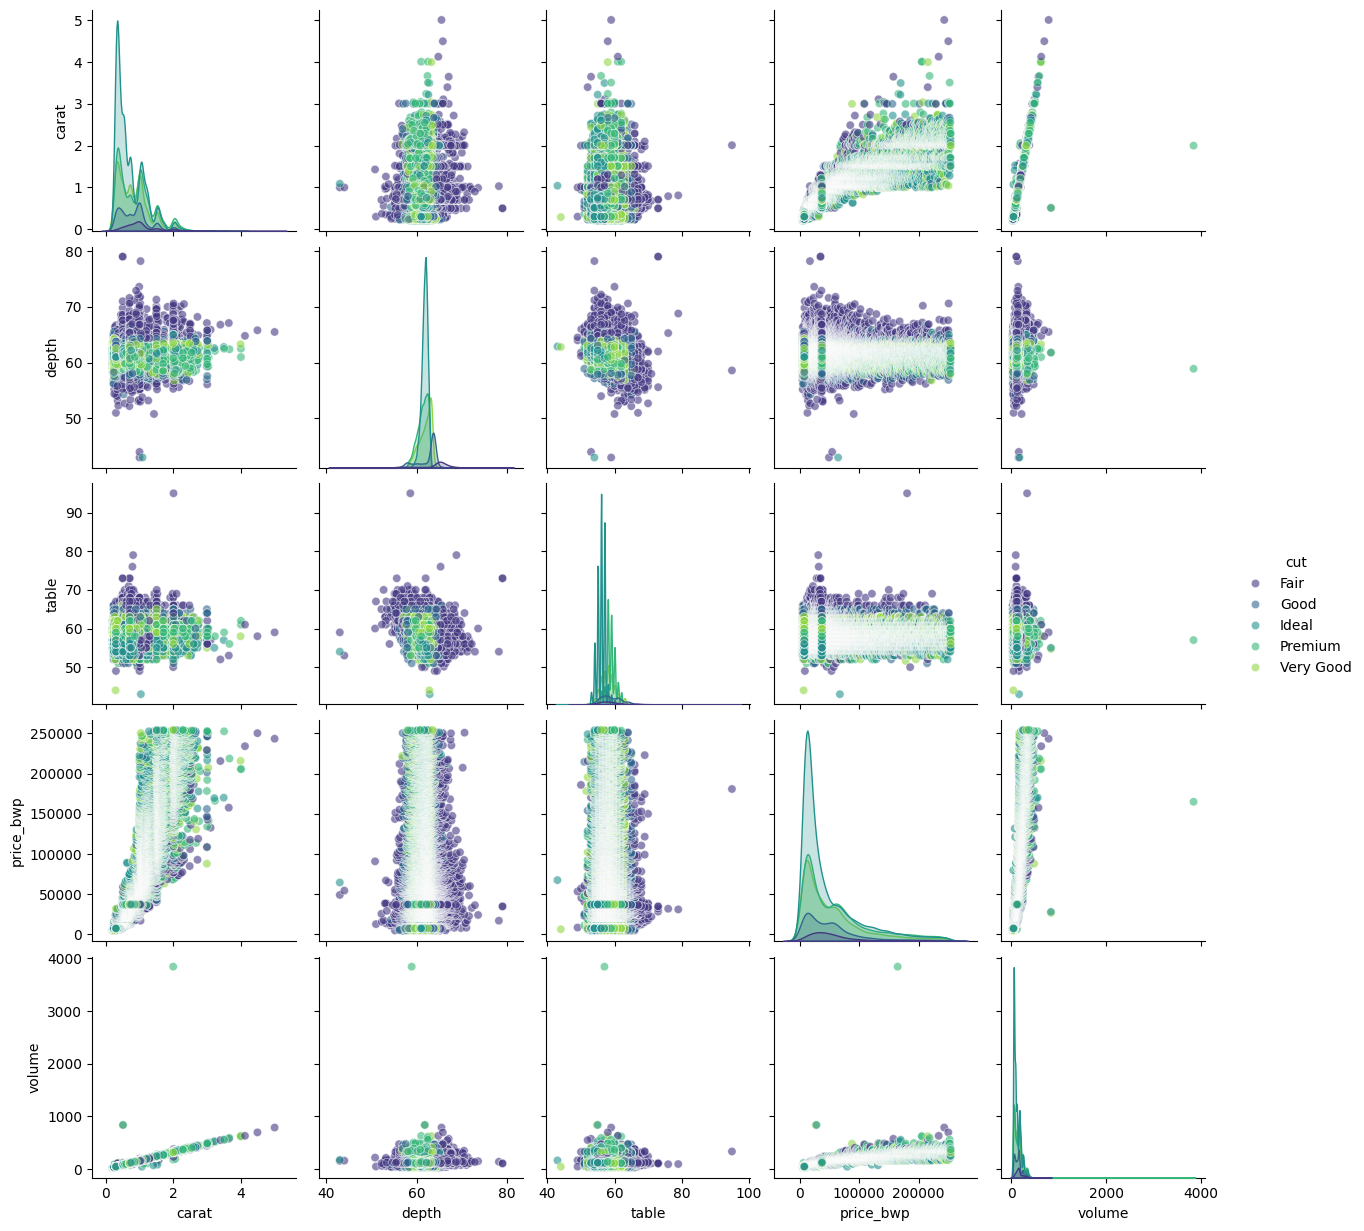

In [5]:
sns.pairplot(df_filtered, vars=numeric_cols, 
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

some obvious outliers... lets take of them.

In [6]:

def remove_outliers_iqr(df, factor=2.0):
    """
    Remove outliers from numeric columns using IQR filtering.
    """
    df_filtered = df.copy()
    
    for col in numeric_cols:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & 
                                  (df_filtered[col] <= upper_bound)]
    
    return df_filtered


df_clean = remove_outliers_iqr(df_filtered)

print(df_clean.shape)

(50467, 8)


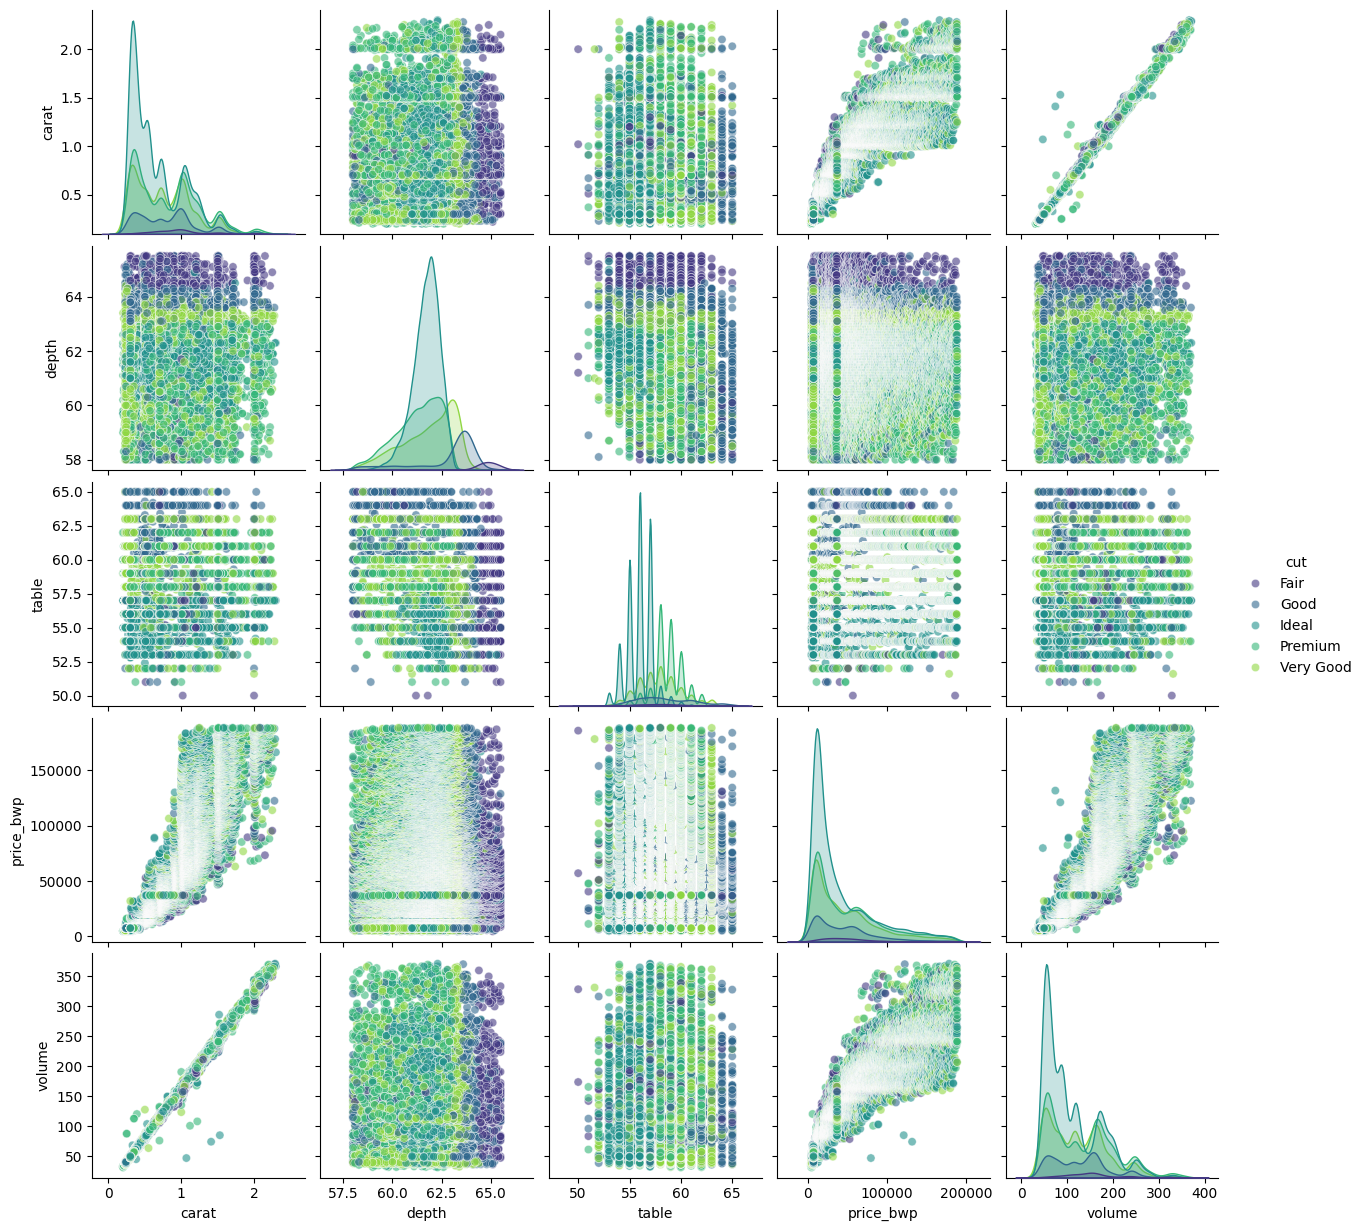

In [7]:
sns.pairplot(df_clean, vars=numeric_cols, 
             hue='cut', palette='viridis', plot_kws={'alpha':0.6})

its a much better cleaner df

## Basic Statistics & Distributions

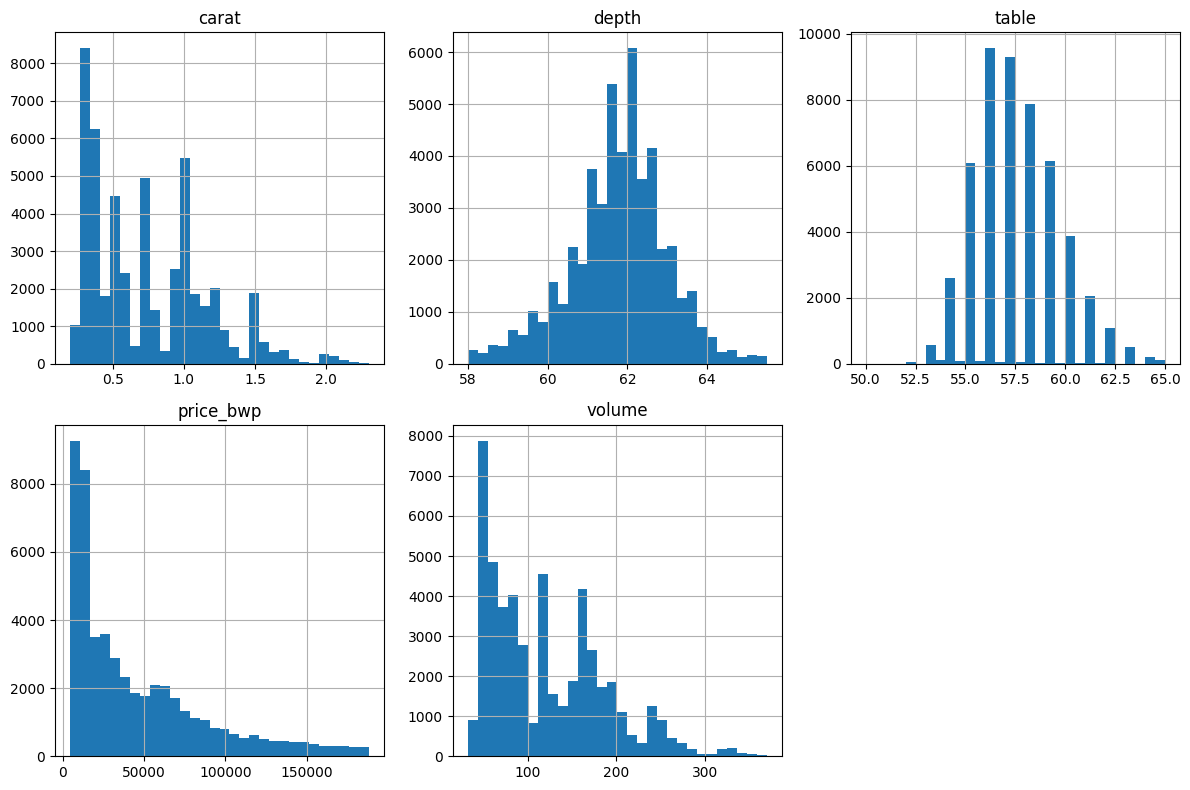

In [8]:
df_clean[numeric_cols].hist(bins=30, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()

* price skewed, makes sense,
* depth and table normal distributed, 
* volume multimodal

# Multivariate Analysis

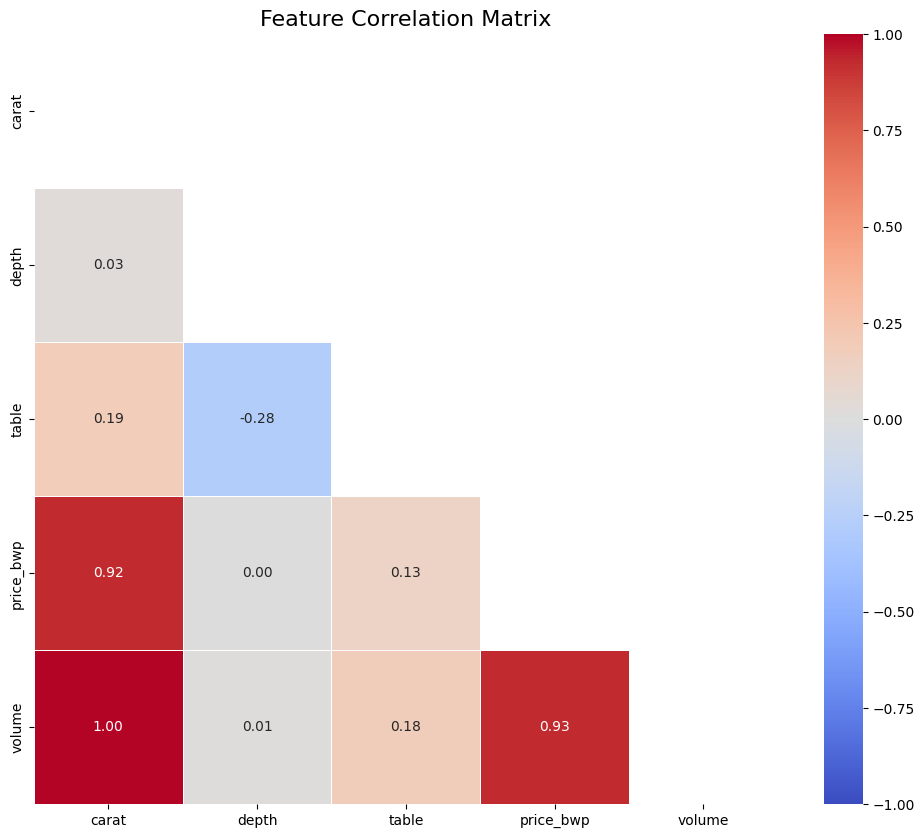

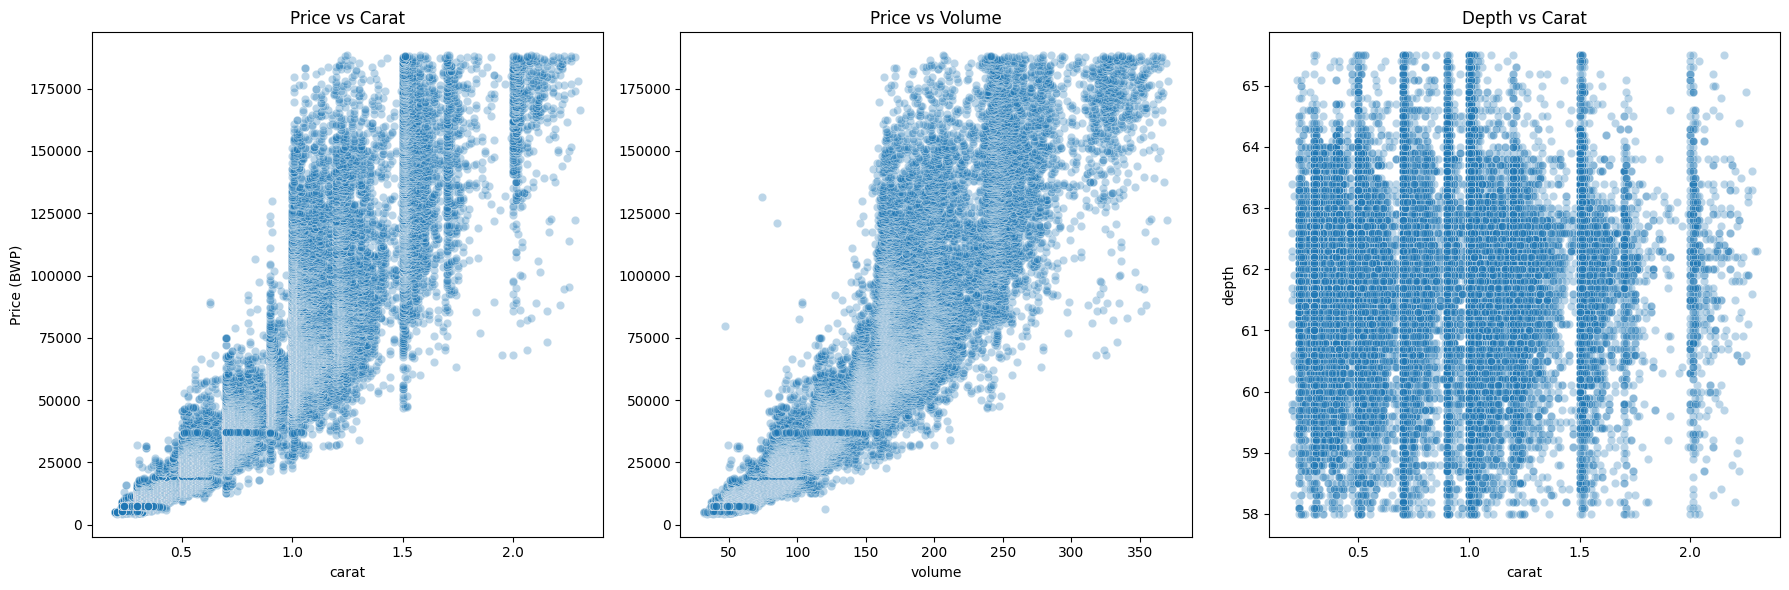

In [9]:
# Correlation matrix
corr = df_clean.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

# Scatter plots of key relationships
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x='carat', y='price_bwp', data=df_clean, alpha=0.3, ax=axes[0])
axes[0].set_title('Price vs Carat')
axes[0].set_ylabel('Price (BWP)')

sns.scatterplot(x='volume', y='price_bwp', data=df_clean, alpha=0.3, ax=axes[1])
axes[1].set_title('Price vs Volume')
axes[1].set_ylabel('')

sns.scatterplot(x='carat', y='depth', data=df_clean, alpha=0.3, ax=axes[2])
axes[2].set_title('Depth vs Carat')

plt.tight_layout()
plt.show()

**Price variation across categories**

In [10]:
categorical_cols = ['cut', 'color', 'clarity']
for col in categorical_cols:
    print(f"\nPrice statistics by {col}:")
    print(df_clean.groupby(col,observed=True)['price_bwp'].describe())


Price statistics by cut:
             count          mean           std     min        25%       50%  \
cut                                                                           
Fair         759.0  54868.428854  38285.683661  4549.5  28215.000  46197.00   
Good        4344.0  46581.454765  38819.185776  4522.5  14050.125  37651.50   
Ideal      20834.0  40817.325166  41011.787208  4401.0  11677.500  23328.00   
Premium    12966.0  52150.405252  45136.556890  4401.0  13624.875  37833.75   
Very Good  11564.0  46961.447423  41878.071517  4536.0  11853.000  33648.75   

                 75%       max  
cut                             
Fair       69099.750  187015.5  
Good       63635.625  188406.0  
Ideal      57209.625  188325.0  
Premium    75586.500  188338.5  
Very Good  67081.500  188365.5  

Price statistics by color:
         count          mean           std     min      25%       50%  \
color                                                                   
D       6498.0 

---

## Key Insights from EDA:

1. **Correlations**:
   - strong corelation between price , carat and volume, not suprising.
   - medium corelation between depth and table , others not so significant

2. **Quality Characteristics**:
   - Cut: Most diamonds are "Ideal" or "Premium" cut
   - Color: G and H colors are most common
   - Clarity: SI1 and VS2 clarity grades dominate the dataset

3. **Important Relationships**:
   - Carat has the strongest correlation with price (r=0.92)
   - Higher quality grades (better cut, better color, better clarity) command higher prices per carat
   - Volume shows a slightly stronger correlation with price than individual dimensions

4. **Unexpected Findings**:
   - Premium cut diamonds have higher median prices than Ideal cuts
   - J color diamonds have higher prices than I color due to larger average size
   - Depth between 58-64% and table between 53-59% are most common



## Lets throw classical models at it; 

In [11]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [12]:

# --- 1. Define features and target ---
X = df_clean.drop('price_bwp', axis=1)
y = df_clean['price_bwp']

# --- 2. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)


# save splits
data_splits = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

with open("Data/diamond_data_splits.pkl", "wb") as f:
    pickle.dump(data_splits, f)


In [13]:
# --- 1. Define categorical and numerical features ---
categorical_features = df_clean.select_dtypes(include='object').columns.tolist()
numerical_features = df_clean.select_dtypes(include=np.number).drop('price_bwp', axis=1).columns.tolist()

# --- 2. Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# --- 3. Define pipelines for different regressors ---
pipelines = {
    'LinearRegression': Pipeline([('preprocessor', preprocessor),
                                  ('model', LinearRegression())]),
    'DecisionTree': Pipeline([('preprocessor', preprocessor),
                              ('model', DecisionTreeRegressor(random_state=7))]),
    'RandomForest': Pipeline([('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=7, n_jobs=-1))]),
    'KNeighbors': Pipeline([('preprocessor', preprocessor),
                            ('model', KNeighborsRegressor())]),
    'XGBRegressor': Pipeline([('preprocessor', preprocessor),
                              ('model', XGBRegressor(random_state=7, verbosity=0, n_jobs=-1))])
}


In [14]:
# --- 4. Train and evaluate each model ---
results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)  # <-- MAE
    

    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2, 'MAE': mae})


In [21]:
results

[{'Model': 'LinearRegression',
  'RMSE': np.float64(16076.47640339492),
  'R2': 0.8562382963132654,
  'MAE': 10639.522092123969},
 {'Model': 'DecisionTree',
  'RMSE': np.float64(18735.174850090487),
  'R2': 0.8047563233783521,
  'MAE': 10001.592257611612},
 {'Model': 'RandomForest',
  'RMSE': np.float64(14591.734702552701),
  'R2': 0.881566292173278,
  'MAE': 8323.785348397858},
 {'Model': 'KNeighbors',
  'RMSE': np.float64(15831.322147802493),
  'R2': 0.8605893831822273,
  'MAE': 9312.508433066498},
 {'Model': 'XGBRegressor',
  'RMSE': np.float64(14880.708788611757),
  'R2': 0.8768289307571088,
  'MAE': 8705.794076003296}]

In [22]:
# --- 5. Display results sorted by RMSE ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')
print(results_df)

              Model          RMSE        R2           MAE
2      RandomForest  14591.734703  0.881566   8323.785348
4      XGBRegressor  14880.708789  0.876829   8705.794076
3        KNeighbors  15831.322148  0.860589   9312.508433
0  LinearRegression  16076.476403  0.856238  10639.522092
1      DecisionTree  18735.174850  0.804756  10001.592258


TabNet Regressor Results ---

R-squared (R²): 0.8757

Mean Absolute Error (MAE): 8983.45 BWP

Root Mean Squared Error (RMSE): 14946.71 BWP

In [23]:
from pytorch_tabnet.tab_model import TabNetRegressor
import numpy as np
import torch

In [24]:
numerical_features
categorical_features

[]

In [25]:
# The ColumnTransformer will output a NumPy array of preprocessed features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# TabNet requires the target variable (y) to be a NumPy array and typically 2D
y_train_processed = y_train.values.reshape(-1, 1)
y_test_processed = y_test.values.reshape(-1, 1)

In [20]:
y_train_processed

array([[ 49788. ],
       [  8181. ],
       [145746. ],
       ...,
       [  5278.5],
       [ 66798. ],
       [ 35397. ]], shape=(37850, 1))

In [26]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# --- 3. Define the TabNet model ---
tabnet_model = TabNetRegressor(
    n_d=8,             # Dimension of the prediction layer
    n_a=8,             # Dimension of the attention embedding
    n_steps=3,         # Number of decision steps
    gamma=1.3,         # Feature reusage coefficient
    lambda_sparse=1e-3, # Sparsity loss coefficient
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type='sparsemax',
    verbose=0,
    seed=7
)

# --- 4. Train the TabNet model ---
# TabNet's fit method includes built-in early stopping (patience)
# The data is passed as NumPy arrays
tabnet_model.fit(
    X_train=X_train_processed, 
    y_train=y_train_processed,
    eval_set=[(X_test_processed, y_test_processed)], # Use test set for early stopping
    eval_metric=['rmse'], # Metric to monitor for evaluation
    max_epochs=100,
    patience=10, # Stop if no improvement after 10 epochs
    batch_size=1024,
    virtual_batch_size=128
)

# --- 5. Evaluate TabNet ---
y_pred_tabnet = tabnet_model.predict(X_test_processed)

# Calculate metrics
R2_tabnet = r2_score(y_test, y_pred_tabnet)
MAE_tabnet = mean_absolute_error(y_test, y_pred_tabnet)
RMSE_tabnet = np.sqrt(mean_squared_error(y_test, y_pred_tabnet))

print("--- TabNet Regressor Results ---")
print(f"R-squared (R²): {R2_tabnet:.4f}")
print(f"Mean Absolute Error (MAE): {MAE_tabnet:.2f} BWP")
print(f"Root Mean Squared Error (RMSE): {RMSE_tabnet:.2f} BWP")


Early stopping occurred at epoch 60 with best_epoch = 50 and best_val_0_rmse = 15395.15666


/home/soot/Code/GemAI/.venv/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


--- TabNet Regressor Results ---
R-squared (R²): 0.8682
Mean Absolute Error (MAE): 9095.43 BWP
Root Mean Squared Error (RMSE): 15395.16 BWP
